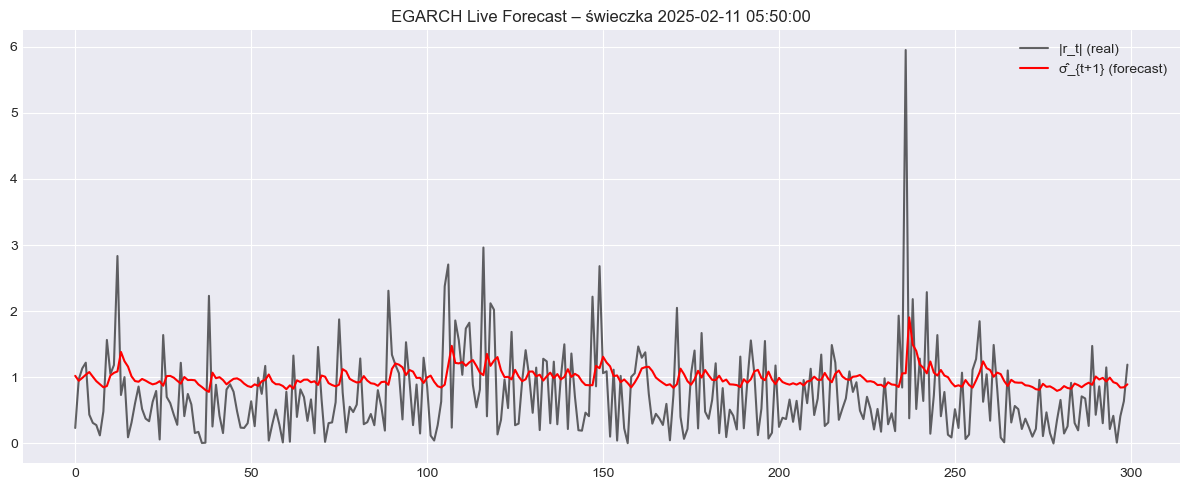

In [6]:
# ===========================================
# 06_EGARCH_Live_Forward.ipynb
# -------------------------------------------
# Test "live" dla modelu EGARCH (forward recursion, no look-ahead)
# ===========================================

import os
import sys
from pathlib import Path

# --- 1️⃣ Ustawienie ścieżki projektu ---
project_root = Path.cwd()
while project_root.name != "ETH-volitality-fotecasting" and project_root.parent != project_root:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"📂 Ścieżka projektu ustawiona na: {project_root}")

# --- 2️⃣ Import poprawionego symulatora ---
from src.simulation_live_egarch import simulate_egarch_live_forward

# --- 3️⃣ Konfiguracja testu ---
csv_path = str(project_root / "candles" / "3000_sample.csv")
model_file = "egarch_ETH_5m_p1_o2_q2_t.pkl"   # dopasuj nazwę pliku do tego, który masz w logs/
n_obs = 3100
delay = 0.001
smoothing = 0.1

# --- 4️⃣ Uruchomienie symulacji ---
result_df = simulate_egarch_live_forward(
    csv_path=csv_path,
    model_filename=model_file,
    n_obs=n_obs,
    delay=delay,
    smoothing=smoothing
)

# --- 5️⃣ Podsumowanie wyników ---
print("\n✅ Symulacja zakończona.")
print(result_df.head())
print(f"\nŚrednia σ_pred: {result_df['sigma_pred'].mean():.4e}")
print(f"Średnia |r|: {result_df['r_abs'].mean():.4e}")
print(f"Korelacja σ_pred vs |r|: {result_df['sigma_pred'].corr(result_df['r_abs']):.4f}")


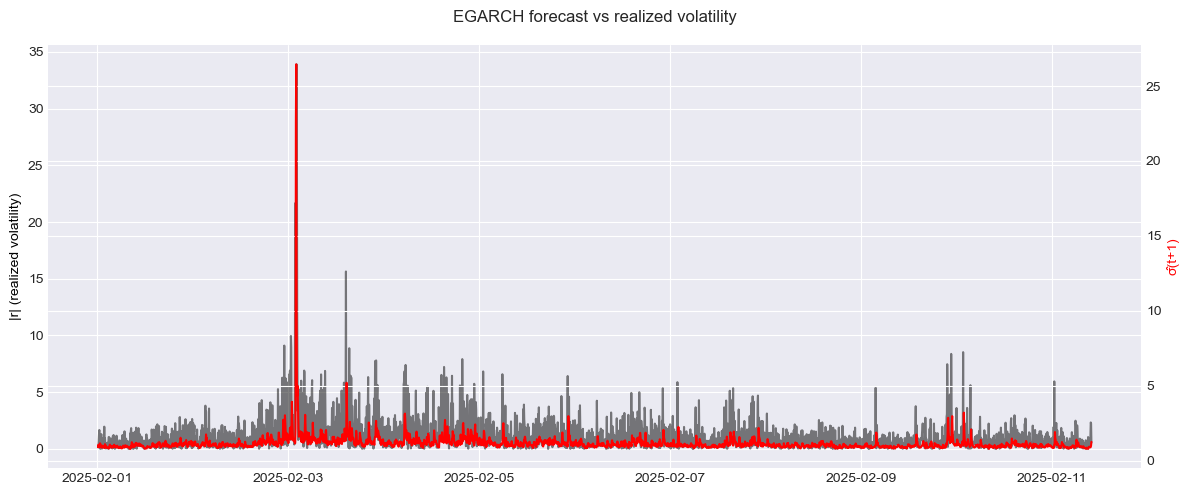

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(result_df["open_time"], result_df["r_abs"],
         color="black", alpha=0.5, label="|r| (real)")
ax1.set_ylabel("|r| (realized volatility)", color="black")

ax2 = ax1.twinx()
ax2.plot(result_df["open_time"], result_df["sigma_pred"],
         color="red", label="σ̂(t+1) (forecast)")
ax2.set_ylabel("σ̂(t+1)", color="red")

fig.suptitle("EGARCH forecast vs realized volatility")
fig.tight_layout()
plt.show()


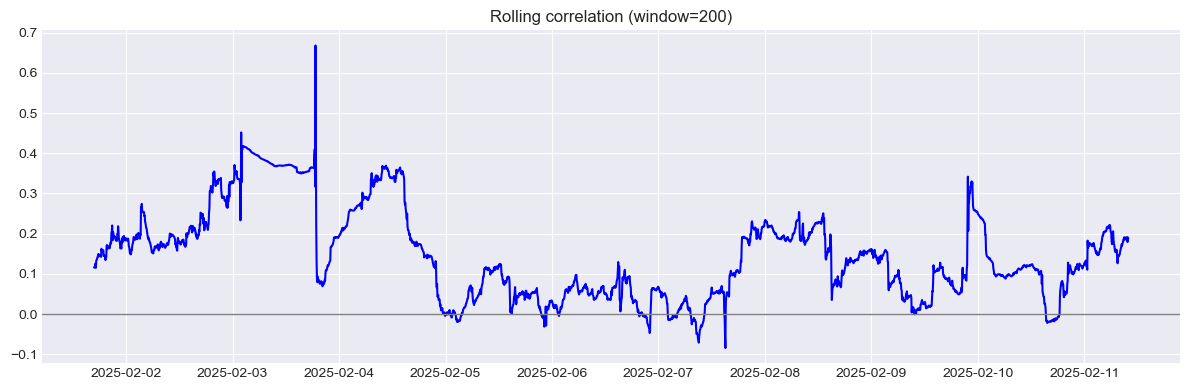

In [9]:
import numpy as np
window = 200
rolling_corr = result_df["sigma_pred"].rolling(window).corr(result_df["r_abs"])

plt.figure(figsize=(12,4))
plt.plot(result_df["open_time"], rolling_corr, color="blue")
plt.title(f"Rolling correlation (window={window})")
plt.axhline(0, color="gray", lw=1)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

candles_path = project_root / "candles" / "3000_sample.csv"
df_candles = pd.read_csv(candles_path, parse_dates=["open_time"])
print(df_candles.head())


In [12]:
start_t = result_df["open_time"].min()
end_t   = result_df["open_time"].max()

df_sub = df_candles[
    (df_candles["open_time"] >= start_t) &
    (df_candles["open_time"] <= end_t)
]


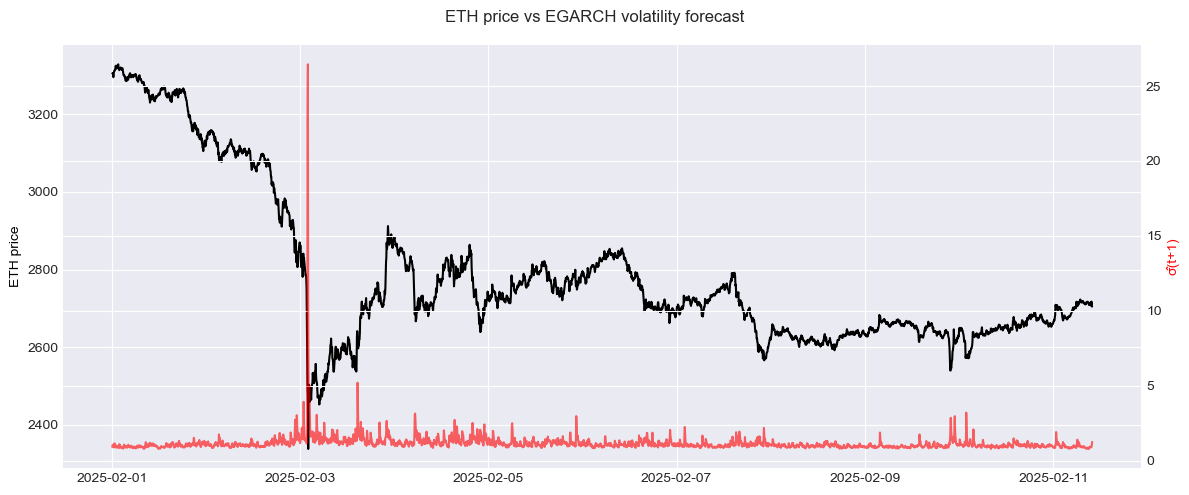

In [14]:
fig, ax1 = plt.subplots(figsize=(12,5))

# cena
ax1.plot(df_sub["open_time"], df_sub["close"], color="black", label="ETH close")
ax1.set_ylabel("ETH price", color="black")

# sigma
ax2 = ax1.twinx()
ax2.plot(result_df["open_time"], result_df["sigma_pred"], color="red", alpha=0.6, label="σ̂(t+1)")
ax2.set_ylabel("σ̂(t+1)", color="red")

fig.suptitle("ETH price vs EGARCH volatility forecast")
fig.tight_layout()
plt.show()


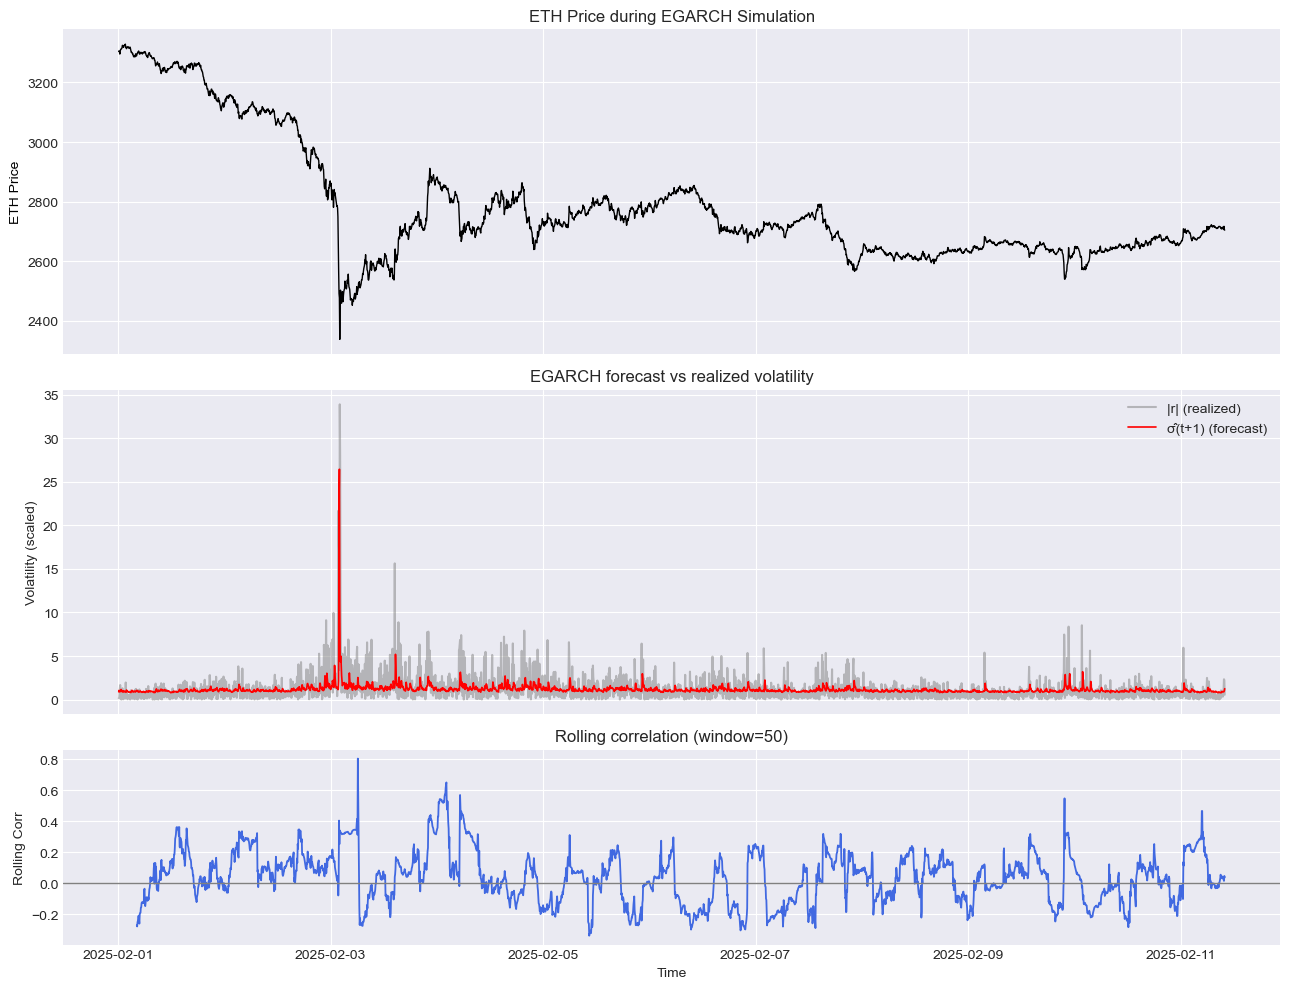

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1️⃣ Wczytaj dane ceny ---
candles_path = project_root / "candles" / "3000_sample.csv"
df_candles = pd.read_csv(candles_path, parse_dates=["open_time"])

# dopasuj zakres do symulacji
start_t = result_df["open_time"].min()
end_t   = result_df["open_time"].max()

df_price = df_candles[
    (df_candles["open_time"] >= start_t) &
    (df_candles["open_time"] <= end_t)
].copy()

# --- 2️⃣ Oblicz rolling correlation ---
window = 50
result_df["rolling_corr"] = result_df["sigma_pred"].rolling(window).corr(result_df["r_abs"])

# --- 3️⃣ Stwórz 3 zsynchronizowane wykresy ---
fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1, 0.6]})

# 🔹 (1) Cena ETH
axes[0].plot(df_price["open_time"], df_price["close"], color="black", linewidth=1)
axes[0].set_ylabel("ETH Price", color="black")
axes[0].set_title("ETH Price during EGARCH Simulation")

# 🔹 (2) Zmienność: σ̂(t+1) vs |r(t+1)|
axes[1].plot(result_df["open_time"], result_df["r_abs"], color="gray", alpha=0.5, label="|r| (realized)")
axes[1].plot(result_df["open_time"], result_df["sigma_pred"], color="red", linewidth=1.2, label="σ̂(t+1) (forecast)")
axes[1].legend()
axes[1].set_ylabel("Volatility (scaled)")
axes[1].set_title("EGARCH forecast vs realized volatility")

# 🔹 (3) Rolling correlation
axes[2].plot(result_df["open_time"], result_df["rolling_corr"], color="royalblue", linewidth=1.3)
axes[2].axhline(0, color="gray", lw=1)
axes[2].set_ylabel("Rolling Corr")
axes[2].set_xlabel("Time")
axes[2].set_title(f"Rolling correlation (window={window})")

plt.tight_layout()
plt.show()
